In [1]:
# import libraries related to Dickey–Fuller, SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
# remove all the warnings.
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_raw = pd.read_csv("/content/Data.csv", index_col=['Date'], parse_dates=['Date']) # parse date function not working with excel.

In [5]:
# Convert Object to String. Then remove comma and convert to integer.
def deleteCommma(x):
    x = str(x)
    return int(x.replace(',',''))

In [6]:
# Iterate over each value of 'Monthly Usage', run deleteComma function and store value to new list.
newData = []
for x in df_raw['Monthly Usage']:
    newData.append(deleteCommma(x))

In [7]:
# Create a new column with the new values.
df_raw['usage'] = newData

In [8]:
# Remove the 'Monthly Usage' column
df_raw = df_raw.drop('Monthly Usage',1)

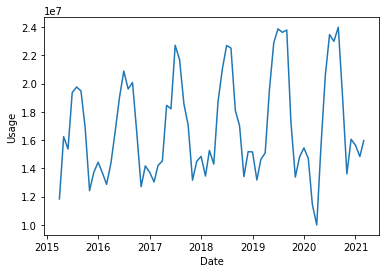

In [9]:
# Plot the data
plt.xlabel('Date')
plt.ylabel('Usage')
plt.plot(df_raw)

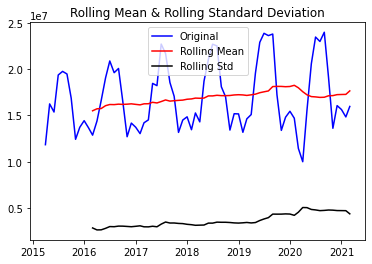

In [14]:
rolling_mean = df_raw.rolling(window = 12).mean()
rolling_std = df_raw.rolling(window = 12).std()
plt.plot(df_raw, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [17]:
result = adfuller(df_raw['usage'])
print('p-value: '+ str(result[1]))

p-value: 0.2966650183407237


In [18]:
## p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.

In [98]:
# split the data in two halfs. One for training and one for testing.
train, test = train_test_split(df_raw, test_size=0.20,shuffle=False)

In [106]:
# Get all the dates in test data
dateX = test.reset_index().Date

In [107]:
dateX

0    2020-01-01
1    2020-02-01
2    2020-03-01
3    2020-04-01
4    2020-05-01
5    2020-06-01
6    2020-07-01
7    2020-08-01
8    2020-09-01
9    2020-10-01
10   2020-11-01
11   2020-12-01
12   2021-01-01
13   2021-02-01
14   2021-03-01
Name: Date, dtype: datetime64[ns]

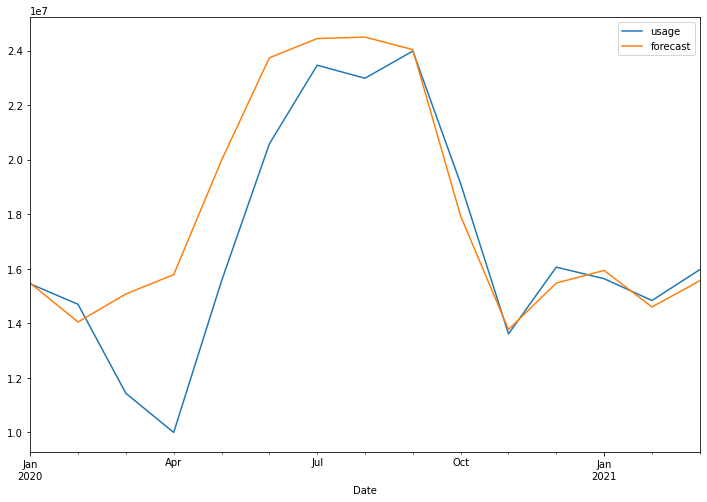

In [115]:
model=sm.tsa.statespace.SARIMAX(train['usage'],order=(2, 0, 2),seasonal_order=(2,1,1,12))
results=model.fit() # train the data
test['forecast']=results.predict(start=dateX.iloc[0],end=dateX.iloc[-1], dynamic=True) # predict values in specific time range
test[['usage','forecast']].plot(figsize=(12,8))

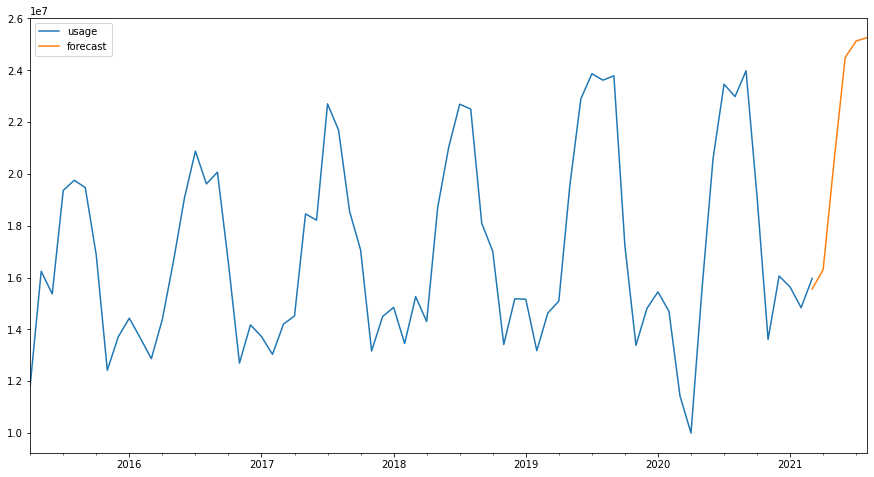

In [116]:
from pandas.tseries.offsets import DateOffset
future_dates=[df_raw.index[-1]+ DateOffset(months=x)for x in range(0,6)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df_raw.columns)

future_df=pd.concat([df_raw,future_datest_df])

future_df['forecast'] = results.predict(start='2021-03-01',end='2021-09-01')
future_df[['usage', 'forecast']].plot(figsize=(15, 8))

2021-03-01    1.555740e+07
2021-04-01    1.629980e+07
2021-05-01    2.052647e+07
2021-06-01    2.449416e+07
2021-07-01    2.513439e+07
2021-08-01    2.525837e+07
Name: forecast, dtype: float64


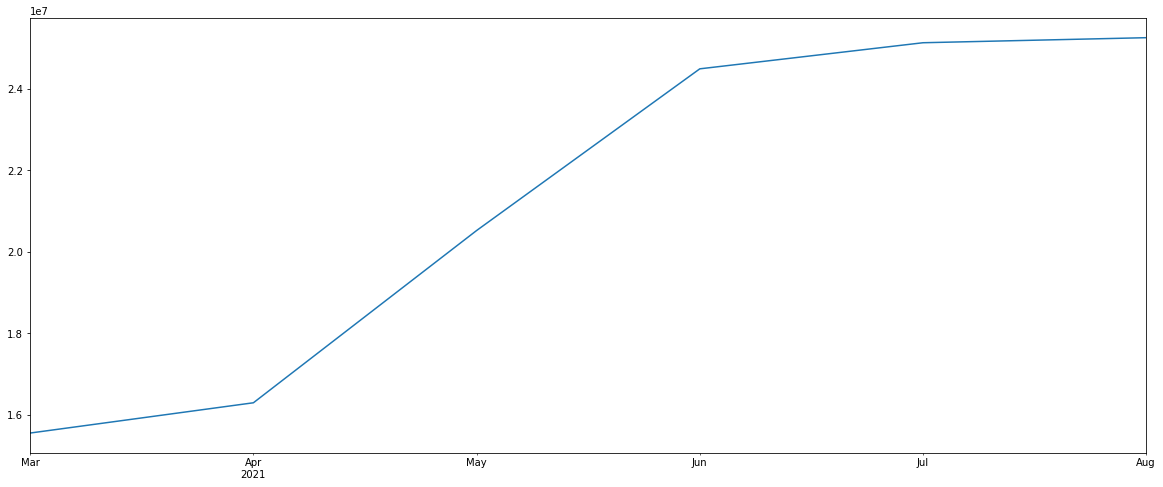

In [117]:
future_df['forecast'].dropna().plot(figsize=(20, 8))
print(future_df['forecast'].dropna())

In [118]:
# Mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [121]:
# Mean absolute error on test data
mean_absolute_percentage_error(df_raw['usage'].loc[dateX.iloc[0]:dateX.iloc[-1]], results.predict(start=dateX.iloc[0],end=dateX.iloc[-1]))

11.082455392629038

In [122]:
# Mean absolute error on overall data
mean_absolute_percentage_error(df_raw['usage'].loc['2016-03-01':'2021-03-01'], results.predict(start='2016-03-01',end='2021-03-01'))

7.451426153451013